In [1]:
import numpy as np
import pandas as pd

import os
import pickle
import glob
import matplotlib.pyplot as plt
import time
import keras
import tensorflow as tf
import imageio
from scipy import signal
from keras.models import load_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import explained_variance_score
from sklearn.metrics import roc_curve, auc
from skimage.transform import resize
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
save_figures = False
file_ending = '.png'
model_string = 'NMDA'

dataset_folder = '../data'

models_folder     = os.path.join(dataset_folder, 'Models')
morphology_folder = os.path.join(dataset_folder, 'Morphology')
test_data_folder  = os.path.join(dataset_folder, 'Data_test')
#auxiliary_folder  = os.path.join(dataset_folder, 'Auxiliary')

model_filename           = os.path.join(models_folder, 'NMDA_TCN__DWT_7_128_153__model.h5')
model_metadata_filename  = os.path.join(models_folder, 'NMDA_TCN__DWT_7_128_153__training.pickle')
morphology_filename      = os.path.join(morphology_folder, 'morphology_dict.pickle')
#NN_illustration_filename = os.path.join(auxiliary_folder, 'TCN_7_layers.png')
test_files               = sorted(glob.glob(os.path.join(test_data_folder, '*_128_simulationRuns*_6_secDuration_*')))

print('-----------------------------------------------')
print('finding files: morphology and test data')
print('-----------------------------------------------')
#print('model found          : "%s"' %(model_filename.split('/')[-1]))
print('model metadata found : "%s"' %(model_metadata_filename.split('/')[-1]))
print('morphology found     : "%s"' %(morphology_filename.split('/')[-1]))
print('number of test files is %d' %(len(test_files)))
print('-----------------------------------------------')

-----------------------------------------------
finding files: morphology and test data
-----------------------------------------------
model metadata found : "NMDA_TCN__DWT_7_128_153__training.pickle"
morphology found     : "morphology_dict.pickle"
number of test files is 12
-----------------------------------------------


In [3]:
testing_3 = test_files[1]
experiment_dict = pickle.load(open(testing_3, "rb" ), encoding='latin1')


In [121]:
experiment_dict.keys()
df = pd.DataFrame(experiment_dict)
df

,Params,Results
useActiveDendrites,True,NaN
randomSeed,100511,NaN
collectAndSaveDVTs,True,NaN
numOutputSpikesPerSim,"[5, 7, 0, 0, 0, 12, 0, 0, 0, 2, 31, 8, 6, 19, ...",NaN
averageOutputFrequency,0.776042,NaN
numSimulations,128,NaN
totalSimDurationInSec,6,NaN
num_bas_ex_spikes_per_100ms_range,"[0, 750]",NaN
totalNumSimulationSeconds,768,NaN
allSegmentsLength,"[24.200878230108255, 15.18219623504249, 21.664...",NaN


In [5]:
opening_files = test_files[:3]

In [117]:
def large_dataframe(file):
    experiment_dict = pickle.load(open(file, "rb"), encoding='latin1')
    df = pd.DataFrame(experiment_dict)
    df.drop('Results', inplace=True, axis=1)
    df = df.loc[['allSegmentsType', 'allSegmentsLength', 'allSegments_SectionInd', 'allSegments_DistFromSoma', 'allSegments_SectionDistFromSoma']]
    df = df.T.apply(pd.Series.explode).reset_index()
    df.drop('index', inplace=True, axis=1)
    return df

def small_dataframe(file):
    experiment_dict = pickle.load(open(file, "rb"), encoding='latin1')
    df = pd.DataFrame(experiment_dict)
    df.drop('Results', inplace=True, axis=1)
    df = df.loc[['allSectionsType', 'allSectionsLength', 'allSections_DistFromSoma']]
    df = df.T.apply(pd.Series.explode).reset_index()
    df.drop('index', inplace=True, axis=1)
    return df

def whole_dataframe(file):
    experiment_dict = pickle.load(open(file, "rb"), encoding='latin1')
    df = pd.DataFrame(experiment_dict)
    df.drop('Results', inplace=True, axis=1)
    df = df.loc[['allSectionsType', 'allSectionsLength', 'allSections_DistFromSoma', 'allSegmentsType', 'allSegmentsLength', 'allSegments_SectionInd', 'allSegments_DistFromSoma', 'allSegments_SectionDistFromSoma']]
    df = df.T.apply(pd.Series.explode)

    return df
#df_sub = df.loc[['allSectionsType', 'allSectionsLength', 'allSections_DistFromSoma']]

#df_sub.T.apply(pd.Series.explode).reset_index()
# stratify on column for basal/apical - use labelencoder

In [118]:
def multi_df(files, opener):
    lst_df = []
    for file in files:
        lst_df.append(opener(file))
        
    return pd.concat(lst_df)



In [119]:
'''testing = test_files[:3]
dfs = multi_df(testing)''' #testing the definitions

'testing = test_files[:3]\ndfs = multi_df(testing)'

In [122]:
#whole_df = multi_df(test_files, whole_dataframe)

In [116]:
dfs = multi_df(test_files, large_dataframe)

In [30]:
df_193 = multi_df(test_files, small_dataframe)

In [33]:
df_193.drop('index', inplace=True, axis=1)


In [127]:
df_193['index'] = df_193.index
df_193

,allSectionsType,allSectionsLength,allSections_DistFromSoma,index
0,basal,24.2009,11.5847,0
1,basal,15.1822,35.7856,1
2,basal,151.651,50.9678,2
3,basal,7.45563,50.9678,3
4,basal,92.5758,58.4234,4
...,...,...,...,...
188,apical,23.3443,57.7203,188
189,apical,93.6788,81.0646,189
190,apical,22.0852,81.0646,190
191,apical,36.0978,103.15,191


In [132]:
idx = dfs['allSegments_SectionInd']
#dfs.drop('index', inplace = True, axis=1)
dfs['index'] = dfs['allSegments_SectionInd']
dfs.join(df_193, on='index')

ValueError: columns overlap but no suffix specified: Index(['index'], dtype='object')

In [41]:
pd.plotting.scatter_matrix(dfs, alpha=0.2)

ValueError: Number of columns must be a positive integer, not 0

<Figure size 432x288 with 0 Axes>

In [45]:
le = LabelEncoder()
dfs['allSegmentsType'] = le.fit_transform(dfs['allSegmentsType'])
#1 = Basal
#0 = apical
df_x = dfs.copy(deep=True)

In [84]:
y = np.array(pd.Series(dfs['allSegmentsType']))
y

array([1, 1, 1, ..., 0, 0, 0])

In [87]:
X = df_x


In [99]:
X

,allSegmentsLength,allSegments_SectionInd,allSegments_DistFromSoma,allSegments_SectionDistFromSoma
0,24.2009,0,23.6851,11.5847
1,15.1822,1,43.3767,35.7856
2,21.6644,2,61.8,50.9678
3,21.6644,2,83.4644,50.9678
4,21.6644,2,105.129,50.9678
...,...,...,...,...
634,18.7358,189,146.64,81.0646
635,18.7358,189,165.375,81.0646
636,22.0852,190,92.1071,81.0646
637,36.0978,191,121.199,103.15


In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33)

In [90]:
lr = LogisticRegression()
model = lr.fit(X_train, y_train)

In [91]:
model.classes_

array([0, 1])

In [92]:
model.intercept_

array([258.13605426])

In [93]:
model.coef_

array([[-4.35335954e-02, -3.11469733e+00,  1.20525703e-04,
         5.48001763e-02]])

In [94]:
model.predict_proba(X_train)

array([[0.00000000e+000, 1.00000000e+000],
       [9.87709310e-001, 1.22906898e-002],
       [1.00000000e+000, 3.81007389e-015],
       ...,
       [1.00000000e+000, 6.83669212e-055],
       [1.00000000e+000, 5.39195951e-105],
       [1.00000000e+000, 1.11164204e-082]])

In [95]:
model.predict(X_train)

array([1, 0, 0, ..., 0, 0, 0])

In [96]:
model.score(X_train, y_train)

1.0

In [97]:
model.score(X_test, y_test)

1.0

In [98]:
confusion_matrix(y_test, model.predict(X_test))

array([[1493,    0],
       [   0, 1038]])

In [70]:
confusion_matrix(y_train, model.predict(X_train))

array([[3031,    0],
       [   0, 2106]])

-True negatives in the upper-left position

-False negatives in the lower-left position

-False positives in the upper-right position

-True positives in the lower-right position

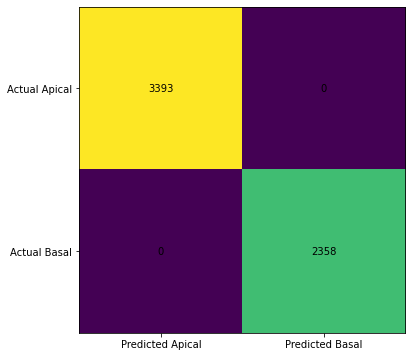

In [59]:
cm = confusion_matrix(y_train, model.predict(X_train))

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Apical', 'Predicted Basal'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Apical', 'Actual Basal'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.show()


In [71]:
print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3031
           1       1.00      1.00      1.00      2106

    accuracy                           1.00      5137
   macro avg       1.00      1.00      1.00      5137
weighted avg       1.00      1.00      1.00      5137



In [72]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1493
           1       1.00      1.00      1.00      1038

    accuracy                           1.00      2531
   macro avg       1.00      1.00      1.00      2531
weighted avg       1.00      1.00      1.00      2531

